# Import functions

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

# HJ PDE Experiment: 1D Quadratic term with initial data J(x) = -|x|

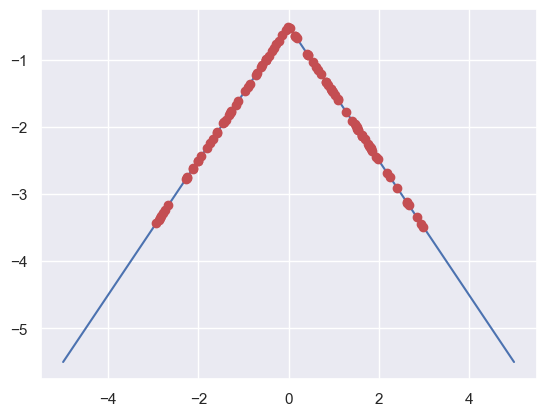

In [6]:
# We consider here the non-convex optimization problem:
# S(y) = min_{x \in \R} \frac{1}{2}(x-y)^{2} -|x|,

# This problem admits the explicit solution
# S(y) = -|y| - 1/2.

# We'll train a Learned Proximal Network to learn the solution
# of this problem from a set of K samples (yk,S(yk))_{k=1}^{K}.

# Function for sampling (yk,S(yk,t))_{k=1}^{K} at a fixed t in one dimension.
def sample_sol_negative_abs(K,mean,stdev):
    """
    Inputs:
        K:  number of samples to generate
        t:  hyperparameter t in the problem
    Outputs:
        y:  a K x 1 matrix of points sampled randomly
            according to a uniform random Gaussian variable
        Sy: a K x 1 vector of points corresponding to the 
            solution S(y,t).
    """
    
    # Generate samples yk and the target function S(yk)
    # Sample uniformly in [-3,3]
    y = -3 + 6*torch.rand(size=(K,1))     #y = torch.normal(mean, stdev, size=(K,1)) 
    Sy = -torch.abs(y) - 1/2
    return y, Sy

# Generate samples
K = 100      # Number of pairs (xk,S(yk,t))
ysamples, Sysamples = sample_sol_negative_abs(K, 0.0, 1.0)

# Plot the actual solution and the samples
ytrue = np.linspace(-5,5,25)
Sytrue = -np.absolute(ytrue) - 1/2

plt.plot(ytrue,Sytrue,'-');
plt.plot(ysamples.numpy(),Sysamples.numpy(),'o', color='r');

# Model parameters

In [7]:
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# Create a model
lpn_model = LPN(in_dim = 1, hidden=hidden, layers=layers, beta=beta).to(device)

print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


# Plot function

In [8]:
# Plotting an LPN model
# function to plot learned prox, convex function, original function
def plot_all(model,ysamples,Sysamples):
    xi = np.linspace(-3, 3, 200)

    y = prox(xi, model)
    c = cvx(xi, model)

    ysamples = ysamples.detach().numpy()
    Sysamples = Sysamples.detach().numpy()

    plt.rcParams["figure.figsize"] = (8, 3)

    # Learned proximal operator
    # TODO: plot the real proximal term
    plt.subplot(1, 4, 1)
    plt.plot(xi, y, "o", ms=5, label="LPN")
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # Convex function (0.5*y^2 - S(y,t))
    plt.subplot(1, 4, 2)
    plt.plot(xi, c, "--", ms=5, label="Cvx func")
    plt.plot(ysamples, 0.5*pow(ysamples,2) - Sysamples, "o", label="ref.")
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # True initial data J(y)
    plt.subplot(1, 4, 3)
    plt.plot(xi, -np.abs(xi), "--", label=r"$-\ell_1$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Initial data")

    # Solution to HJ PDE S(y,t)

    plt.tight_layout()

# Proximal matching loss

In [9]:
# Proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

# Training function

In [10]:
# Defines what is a single iteration in the training of the LPN.
# Note (12/10/2024 -- GPL) Should target by Sysamples, or the convex function?
# Maybe I am making an error there and this is why the plots are bad?

def single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss=None):
    input = ysamples
    target = 0.5*(torch.pow(ysamples,2)) - Sysamples #Sysamples
    
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / K  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / K  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    # if not i % 500:
    #     print("iteration", i, "loss", loss.item(), "loss_lstar", loss_lstar.item())

# Train

L2 loss

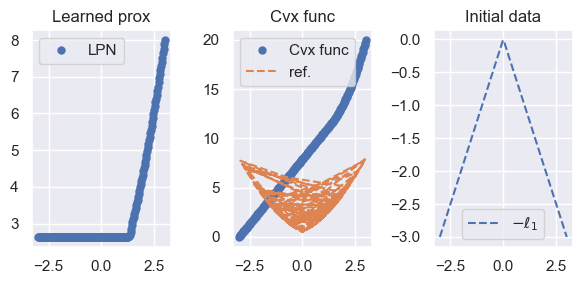

In [11]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-4)
loss_type = 2


# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model,ysamples,Sysamples)
# print(
#     "Values at [-3,-2,-1,0,1,2,3]:",
#     lpn_model(
#         torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
#     ).squeeze(1),
# )


L1 loss

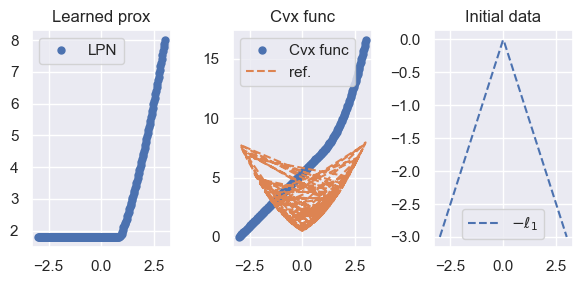

In [12]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
loss_type = 1

# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model,ysamples,Sysamples)

Proximal matching loss with gamma = 0.1

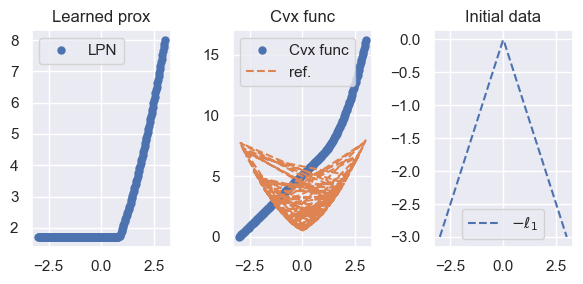

In [13]:
loss_type = 0
gamma_loss = 0.1

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples)

Proximal matching with gamma = 0.01

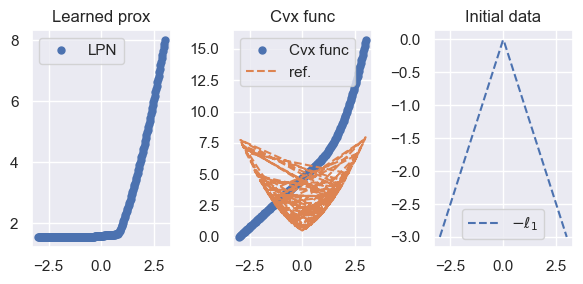

In [14]:
loss_type = 0
gamma_loss = 0.01

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples)